In [160]:
import io
import functools
import itertools
import gzip

import pandas
import requests
import networkx

import eutility

In [5]:
# Read MeSH terms to MeSH names
url = 'https://raw.githubusercontent.com/dhimmel/mesh/e561301360e6de2140dedeaa7c7e17ce4714eb7f/data/terms.tsv'
mesh_df = pandas.read_table(url)

# Read MeSH terms mapped to DO Slim terms
url = 'https://raw.githubusercontent.com/dhimmel/disease-ontology/9fd75f14b17e01bebc97faf1bfa1b9025e9ce4de/data/xrefs-slim.tsv'
doslim_xref_df = pandas.read_table(url)
doslim_xref_df = doslim_xref_df[doslim_xref_df.resource == 'MSH'][['doid_code', 'doid_name', 'resource_id']].rename(columns={'resource_id': 'mesh_id'})
disease_df = doslim_xref_df.merge(mesh_df)
disease_df.to_csv('data/DO-slim-to-mesh.tsv', sep='\t', index=False)
disease_df.head()

,doid_code,doid_name,mesh_id,mesh_name
0,DOID:2531,hematologic cancer,D019337,Hematologic Neoplasms
1,DOID:1319,brain cancer,D001932,Brain Neoplasms
2,DOID:263,kidney cancer,D007680,Kidney Neoplasms
3,DOID:1793,pancreatic cancer,D010190,Pancreatic Neoplasms
4,DOID:4159,skin cancer,D012878,Skin Neoplasms


In [ ]:
# Diseases

In [17]:
rows_out = list()

for i, row in disease_df.iterrows():
    term_query = '{disease}[MeSH Major Topic]'.format(disease = row.mesh_name.lower())
    payload = {'db': 'pubmed', 'term': term_query}
    pmids = eutility.esearch_query(payload, retmax = 10000)
    row['term_query'] = term_query
    row['n_articles'] = len(pmids)
    row['pubmed_ids'] = '|'.join(pmids)
    rows_out.append(row)
    print('{} articles for {}'.format(len(pmids), row.mesh_name))

disease_pmids_df = pandas.DataFrame(rows_out)

7199 articles for Hematologic Neoplasms
98466 articles for Brain Neoplasms
48992 articles for Kidney Neoplasms
45514 articles for Pancreatic Neoplasms
84775 articles for Skin Neoplasms
82806 articles for Bone Neoplasms
53364 articles for Ovarian Neoplasms
186097 articles for Breast Neoplasms
48742 articles for Glioma
88124 articles for Uterine Neoplasms
18380 articles for Adrenal Gland Neoplasms
32981 articles for Esophageal Neoplasms
12012 articles for Salivary Gland Neoplasms
81939 articles for Prostatic Neoplasms
63628 articles for Stomach Neoplasms
37204 articles for Urinary Bladder Neoplasms
14652 articles for Peripheral Nervous System Neoplasms
96253 articles for Liver Neoplasms
3491 articles for Vaginal Neoplasms
207632 articles for Head and Neck Neoplasms
32426 articles for Rectal Neoplasms
28522 articles for Eye Neoplasms
50324 articles for Colonic Neoplasms
19300 articles for Laryngeal Neoplasms
222943 articles for Neoplasms, Germ Cell and Embryonal
7270 articles for Thymus N

In [25]:
with gzip.open('data/disease-pmids.tsv.gz', 'w') as write_file:
    write_file = io.TextIOWrapper(write_file)
    disease_pmids_df.to_csv(write_file, sep='\t', index=False)

In [23]:
# Symptoms

In [162]:
# Read MeSH
url = 'https://raw.githubusercontent.com/dhimmel/mesh/e561301360e6de2140dedeaa7c7e17ce4714eb7f/data/ontology.gexf.gz'
read_file = io.TextIOWrapper(gzip.GzipFile(fileobj=requests.get(url, stream=True).raw))
mesh_network = networkx.read_gexf(read_file)

disease_exlusions = set()
for mesh_id in disease_df.mesh_id:
    disease_exlusions.add(mesh_id)
    disease_exlusions |= networkx.ancestors(mesh_network, mesh_id)
    disease_exlusions |= networkx.descendants(mesh_network, mesh_id)
len(disease_exlusions)

775

In [164]:
symptom_df[symptom_df.mesh_id.isin(disease_exlusions)]

,mesh_id,mesh_name,in_hsdn,term_query,n_articles
13,D000787,Angina Pectoris,1,angina pectoris[MeSH Terms:noexp],30704
14,D000788,"Angina Pectoris, Variant",1,"angina pectoris, variant[MeSH Terms:noexp]",1854
15,D000789,"Angina, Unstable",1,"angina, unstable[MeSH Terms:noexp]",8238
37,D001835,Body Weight,1,body weight[MeSH Terms:noexp],163627
44,D002385,Cataplexy,0,cataplexy[MeSH Terms:noexp],761
103,D005320,Fetal Macrosomia,1,fetal macrosomia[MeSH Terms:noexp],1840
144,D006970,Disorders of Excessive Somnolence,0,disorders of excessive somnolence[MeSH Terms:n...,2703
178,D009290,Narcolepsy,0,narcolepsy[MeSH Terms:noexp],2821
181,D009461,Neurologic Manifestations,1,neurologic manifestations[MeSH Terms:noexp],7314
183,D009765,Obesity,1,obesity[MeSH Terms:noexp],130229


In [24]:
# Read MeSH Symptoms
url = 'https://raw.githubusercontent.com/dhimmel/mesh/e561301360e6de2140dedeaa7c7e17ce4714eb7f/data/symptoms.tsv'
symptom_df = pandas.read_table(url)
symptom_df.head()

,mesh_id,mesh_name,in_hsdn
0,D000006,"Abdomen, Acute",1
1,D000270,Adie Syndrome,0
2,D000326,Adrenoleukodystrophy,0
3,D000334,Aerophagy,1
4,D000370,Ageusia,1


In [ ]:
rows_out = list()

for i, row in symptom_df.iterrows():
    term_query = '{symptom}[MeSH Terms:noexp]'.format(symptom = row.mesh_name.lower())
    payload = {'db': 'pubmed', 'term': term_query}
    pmids = eutility.esearch_query(payload, retmax = 5000, sleep=2)
    row['term_query'] = term_query
    row['n_articles'] = len(pmids)
    row['pubmed_ids'] = '|'.join(pmids)
    rows_out.append(row)
    print('{} articles for {}'.format(len(pmids), row.mesh_name))

In [41]:
symptom_pmids_df = pandas.DataFrame(rows_out)

with gzip.open('data/symptom-pmids.tsv.gz', 'w') as write_file:
    write_file = io.TextIOWrapper(write_file)
    symptom_pmids_df.to_csv(write_file, sep='\t', index=False)

symptom_pmids_df.head()

,mesh_id,mesh_name,in_hsdn,term_query,n_articles,pubmed_ids
0,D000006,"Abdomen, Acute",1,"abdomen, acute[MeSH Terms:noexp]",8465,25669229|25650451|25619050|25608417|25543890|2...
1,D000270,Adie Syndrome,0,adie syndrome[MeSH Terms:noexp],311,24995781|24625775|24215593|23952008|23809464|2...
2,D000326,Adrenoleukodystrophy,0,adrenoleukodystrophy[MeSH Terms:noexp],1506,25583825|25378668|25297370|25275259|25149411|2...
3,D000334,Aerophagy,1,aerophagy[MeSH Terms:noexp],260,25073665|24796405|23772202|23772201|23636521|2...
4,D000370,Ageusia,1,ageusia[MeSH Terms:noexp],220,24825557|24782205|24191925|24137848|24088167|2...


In [130]:
def read_pmids_tsv(path, key, min_articles = 5):
    term_to_pmids = dict()
    pmids_df = pandas.read_table(path, compression='gzip')
    pmids_df = pmids_df[pmids_df.n_articles >= min_articles]
    for i, row in pmids_df.iterrows():
        term = row[key]
        pmids = row.pubmed_ids.split('|')
        term_to_pmids[term] = set(pmids)
    pmids_df.drop('pubmed_ids', axis=1, inplace=True)
    return pmids_df, term_to_pmids

In [131]:
symptom_df, symptom_to_pmids = read_pmids_tsv('data/symptom-pmids.tsv.gz', key='mesh_id')
disease_df, disease_to_pmids = read_pmids_tsv('data/disease-pmids.tsv.gz', key='doid_code')

In [79]:
symptom_pmids = set.union(*symptom_to_pmids.values())
len(symptom_pmids)

1741776

In [80]:
disease_pmids = set.union(*disease_to_pmids.values())
len(disease_pmids)

3413567

In [150]:
def score_pmid_cooccurrence(term0_to_pmids, term1_to_pmids, term0_name='term_0', term1_name='term_1', verbose=True):
    all_pmids0 = set.union(*term0_to_pmids.values())
    all_pmids1 = set.union(*term1_to_pmids.values())
    pmids_in_both = all_pmids0 & all_pmids1
    total_pmids = len(pmids_in_both)
    if verbose:
        print('Total articles containing a {}: {}'.format(term0_name, len(all_pmids0)))
        print('Total articles containing a {}: {}'.format(term1_name, len(all_pmids1)))
        print('Total articles containing both a {} and {}: {}'.format(term0_name, term1_name, total_pmids))
    
    term0_to_pmids = term0_to_pmids.copy()
    term1_to_pmids = term1_to_pmids.copy()
    for d in term0_to_pmids, term1_to_pmids:
        for key, value in list(d.items()):
            d[key] = value & pmids_in_both
            if not d[key]:
                del d[key]
    
    if verbose:
        print('\nAfter removing terms without any cooccurences:')
        print('+ {} {}s remain'.format(len(term0_to_pmids), term0_name))
        print('+ {} {}s remain'.format(len(term1_to_pmids), term1_name))
    
    rows = list()
    for term0, term1 in itertools.product(term0_to_pmids, term1_to_pmids):
        pmids0 = term0_to_pmids[term0]
        pmids1 = term1_to_pmids[term1]

        a = len(pmids0 & pmids1)
        b = len(pmids0) - a
        c = len(pmids1) - a
        d = total_pmids - len(pmids0 | pmids1)
        contingency_table = [[a, b], [c, d]]

        expected = len(pmids0) * len(pmids1) / total_pmids
        enrichment = a / expected
        
        oddsratio, pvalue = scipy.stats.fisher_exact(contingency_table, alternative='greater')
        rows.append([term0, term1, a, expected, enrichment, oddsratio, pvalue])
    
    columns = [term0_name, term1_name, 'cooccurrence', 'expected', 'enrichment', 'odds_ratio', 'p_fisher']
    df = pandas.DataFrame(rows, columns=columns)
    
    if verbose:
        print('\nCooccurrence scores calculated for {} {} -- {} pairs'.format(len(df), term0_name, term1_name))
    return df

In [151]:
cooc_df = score_pmid_cooccurrence(disease_to_pmids, symptom_to_pmids, 'doid_code', 'mesh_id')
cooc_df = symptom_df[['mesh_id', 'mesh_name']].merge(cooc_df)
cooc_df = disease_df[['doid_code', 'doid_name']].merge(cooc_df)
cooc_df = cooc_df.sort(['doid_name', 'p_fisher'])
cooc_df.to_csv('data/disease-symptom-cooccurrence.tsv', index=False, sep='\t')
cooc_df.head()

Total articles containing a doid_code: 3413567
Total articles containing a mesh_id: 1741776
Total articles containing both a doid_code and mesh_id: 392397

After removing terms without any cooccurences:
+ 117 doid_codes remain
+ 424 mesh_ids remain

Cooccurrence scores calculated for 49608 doid_code -- mesh_id pairs


,doid_code,doid_name,mesh_id,mesh_name,cooccurrence,expected,enrichment,odds_ratio,p_fisher
26299,DOID:10652,Alzheimer's disease,D000647,Amnesia,303,12.059837,25.124717,41.357794,0.000000e+00
26360,DOID:10652,Alzheimer's disease,D004314,Down Syndrome,800,32.051845,24.959561,44.925606,0.000000e+00
26450,DOID:10652,Alzheimer's disease,D008569,Memory Disorders,1564,67.100289,23.308394,47.555304,0.000000e+00
26494,DOID:10652,Alzheimer's disease,D011595,Psychomotor Agitation,331,13.675650,24.203603,39.197780,0.000000e+00
26423,DOID:10652,Alzheimer's disease,D006816,Huntington Disease,251,10.884701,23.059889,35.878792,1.152183e-261


In [152]:
import numpy
import scipy
import seaborn
import matplotlib.pyplot as plt

%matplotlib inline

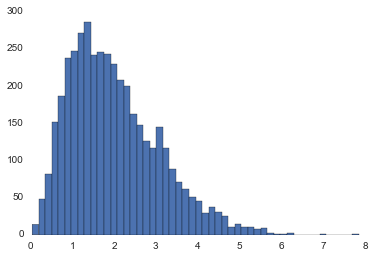

In [158]:
sig_df = cooc_df[cooc_df.p_fisher < 0.05]
plt.hist(list(numpy.log(sig_df.enrichment)), bins = 50);